In [75]:
class Empty(Exception):
    """Error attempting to access an element from an empty container.""" 
    pass

class _DoublyLinkedBase:
    """A base class providing a doubly linked list representation."""

    #-------------------------- nested Node class --------------------------    
    class _Node:
        """Lightweight, nonpublic class for storing a singly linked node."""
        __slots__ = '_element' ,'_prev', '_next' #,'_key','_value'
        def  __init__(self, element,prev, next):
            self._element = element
#             if element is not None:
#                 self._key = element._key
#                 self._value = element._value
            self._prev = prev
            self._next = next
        
    #------------------------------- doubly linked methods -------------------------------
    def __init__ (self):
        """Create an empty list."""
        self._header = self._Node(None,None,None)
        self._trailer = self._Node(None,None,None)
        self._header._next = self._trailer
        self._trailer._prev = self._header
        self._size = 0

    def __len__ (self):
        """Return the number of elements in the list."""
        return self._size

    def is_empty(self):
        """Return True if the list is empty."""
        return self._size == 0  

    def  _insert_between(self, e, predecessor, successor):
        """Add element e between two existing nodes and return new node"""
        newest = self._Node(e,predecessor, successor)
        predecessor._next = newest
        successor._prev = newest 
        self._size += 1
        return newest
    
    def _delete_node(self, node):
        """Delete nonsentinel node from the list and return its element."""
        predecessor = node._prev  
        successor = node._next
        predecessor._next = successor
        successor._prev = predecessor
        self._size -= 1
        element = node._element  # record deleted element
        node._prev = node._next = node._element = None 
        return element

    def __str__(self):
        cur_size = 0
        if self.is_empty():
            raise Empty( 'Queue is empty' )
        else:
            s = '' 
            head =  self._header
            cur_size = self._size
            for i in range(1,self._size+1):
                s += str(self._header._next._element)
                self._header = self._header._next
            self._header = head
            return s

In [77]:
class PositionalList( _DoublyLinkedBase):
    """A sequential container of elements allowing positional access."""
    #-------------------------- nested Position class --------------------------
    class Position:
        """An abstraction representing the location of a single element."""
        def  __init__     (self, container, node):
            """Constructor should not be invoked by user."""
            self._container = container
            self._node = node
        
        def element(self):
            """Return the element stored at this Position."""
            return self._node._element
        
#         def getKeyValue(self):
#             return self._node._key,self._node._value
    
        def  __eq__ (self, other):
            """Return True if other is a Position representing the same location."""
            return type(other) is type(self) and other._node is self._node
        
        def  __ne__ (self, other):
            """Return True if other does not represent the same location."""
            return not (self == other)
        
    #------------------------------- utility method -------------------------------
    def  _validate(self, p):
        """Return position s node, or raise appropriate error if invalid."""
        if not isinstance(p, self.Position):
            raise TypeError( 'p must be proper Position type' )
        if p._container is not self:
            raise ValueError( 'p does not belong to this container' )
        if p._node._next is None: # convention for deprecated nodes
            raise ValueError( 'p is no longer valid' )
        return p._node
        
    #------------------------------- utility method -------------------------------
    def _make_position(self, node):
        """Return Position instance for given node (or None if sentinel)."""
        if node is self._header or node is self._trailer:
            return None                        # boundary violation 
        else:
            return self.Position(self, node)  # legitimate position

    #------------------------------- accessors -------------------------------
    def first(self):
        """Return the first Position in the list (or None if list is empty)."""
        return self._make_position(self._header._next) 

    def last(self):
        """Return the last Position in the list (or None if list is empty)."""
        return self._make_position(self._trailer._prev)

    def before(self, p):
        """Return the Position just before Position p (or None if p is first)."""
        node = self._validate(p)
        return self._make_position(node._prev)
        
    def after(self, p):
        """Return the Position just after Position p (or None if p is first)."""
        node = self._validate(p)
        return self._make_position(node._next)

    def __iter__(self):
        """Generate a forward iteration of the elements of the list."""
        cursor = self.first()
        while cursor is not None:
            yield cursor.element()
            cursor = self.after(cursor)
                
   #------------------------------- mutators -------------------------------
    # override inherited version to return Position, rather than Node 
    def _insert_between(self, e, predecessor, successor):
        """Add element between existing nodes and return new Position."""
        node = super()._insert_between(e, predecessor, successor)
        return self._make_position(node)  

    def add_first(self, e):
        """Insert element e at the front of the list and return new Position."""
        return self._insert_between(e, self._header, self._header._next)

    def add_last(self, e):
        """Insert element e at the back of the list and return new Position."""
        return self._insert_between(e, self._trailer._prev, self._trailer)
        
    def add_before(self,p, e):
        """Insert element e into list before Position p and return new Position."""
        original = self._validate(p)
        return self._insert_between(e, original._prev, original)

    def add_after(self,p, e):
        """Insert element e into list after Position p and return new Position."""
        original = self._validate(p)
        return self._insert_between(e, original, original._next)

    def delete(self,p):
        """Remove and return the element at Position p."""
        original = self._validate(p)
        return self._delete_node(original)

    def replace(self,p, e):
        """Replace the element at Position p with e.

         Return the element formerly at Position p.
        """
        original = self._validate(p)
        old_value = original._element
        original._element = e
        return old_value



In [109]:
class PriorityQueueBase:
    """Abstract base class for a priority queue."""

    class _Item:
        """Lightweight composite to store priority queue items."""
        __slots__ = '_key' , '_value'


        def   __init__ (self, k, v):
            self._key = k
            self._value = v

        def   __lt__ (self, other):
            return self._key < other._key
        
        def __gt__(self,other):
            return self._key > other._key
    
    def is_empty(self):
        """Return True if the priority queue is empty."""
        return len(self) == 0

In [78]:
class UnsortedPriorityQueue(PriorityQueueBase): # base class defines Item
    """A min-oriented priority queue implemented with an unsorted list"""
    
    def _find_min(self): # nonpublic utility
        """Return Position of item with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' ) 
        small = self._data.first()
        walk = self._data.after(small)
        while walk is not None:
            if walk.element() < small.element():
                small = walk
            walk = self._data.after(walk)
        return small
    
    def __init__(self):
        """Create a new empty Priority Queue."""
        self._data = PositionalList()
        
    def __len__(self):
        """Return the number of items in the priority queue."""
        return len(self._data)
    
    def add(self, key, value):
        """Add a key-value pair."""
        self._data.add_last(self._Item(key, value))

    def min(self):
        """Return but do not remove (k,v) tuple with minimum key."""
        p = self._find_min()
        item = p.element()
        return (item._key, item._value)

    def remove_min(self):
        """Remove and return (k,v) tuple with minimum key."""
        p = self._find_min()
        item = self._data.delete(p)
        return (item._key, item._value)
    
    def printQue(self): # nonpublic utility
        """Print priority Queue value"""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' ) 
        d = []
        first = self._data.first()
        item1 = first.element()
        d.append((item1._key,item1._value))
        #d.append(first.getKeyValue())
        second = self._data.after(first)
        
        while second is not None:
            #d.append(second.getKeyValue())
            item2 = second.element()
            d.append((item2._key,item2._value))
            second = self._data.after(second)
                
        return d    
        

UPQ = UnsortedPriorityQueue() 
UPQ.add(5,'A')
UPQ.add(9,'C')
UPQ.add(3,'B')
UPQ.add(7,'D')
UPQ.printQue()
#UPQ.min()
# UPQ.remove_min()
# UPQ.remove_min()
# len(UPQ)
# UPQ.remove_min()
# UPQ.remove_min()
# UPQ.is_empty()
# #UPQ.remove_min()

[(5, 'A'), (9, 'C'), (3, 'B'), (7, 'D')]

In [79]:
class SortedPriorityQueue(PriorityQueueBase): # base class defines Item
    """A min-oriented priority queue implemented with a sorted list"""
    
    
    def __init__(self):
        """Create a new empty Priority Queue."""
        self._data = PositionalList()
        
    def __len__(self):
        """Return the number of items in the priority queue."""
        return len(self._data)
    
    def add(self, key, value):
        """Add a key-value pair."""
        newest = self._Item(key, value)
        walk = self._data.last()
        while walk is not None and newest < walk.element():
            walk = self._data.before(walk)
        if walk is None:
            self._data.add_first(newest)
        else:
            self._data.add_after(walk, newest)
        

    def min(self):
        """Return but do not remove (k,v) tuple with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' )
        p = self._data.first()
        item = p.element()
        return (item._key, item._value)

    def remove_min(self):
        """Remove and return (k,v) tuple with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' )
        item = self._data.delete(self._data.first())
        return (item._key, item._value)
    
    def printQue(self): # nonpublic utility
        """Print priority Queue value"""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' ) 
        d = []
        first = self._data.first()
        item1 = first.element()
        d.append((item1._key,item1._value))
        #d.append(first.getKeyValue())
        second = self._data.after(first)
        
        while second is not None:
            #d.append(second.getKeyValue())
            item2 = second.element()
            d.append((item2._key,item2._value))
            second = self._data.after(second)
                
        return d
    
SPQ = SortedPriorityQueue() 
SPQ.add(5,'A')
SPQ.add(9,'C')
SPQ.add(3,'B')
SPQ.add(7,'D')
SPQ.printQue()    

[(3, 'B'), (5, 'A'), (7, 'D'), (9, 'C')]

###### 
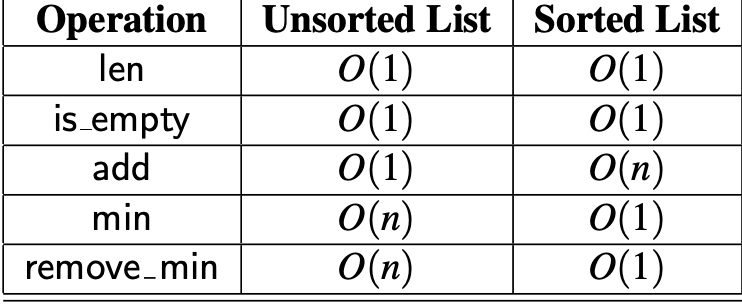

In [106]:
class HeapPriorityQueue(PriorityQueueBase):
    """A min-oriented priority queue implemented with a binary heap."""
    #------------------------------ nonpublic behaviors ------------------------------ 
    def  _parent(self, j):
        return (j-1) // 2
    
    def  _left(self, j):
        return 2*j +1
        
    def  _right(self, j):
        return 2*j +2
    
    def _has_left(self, j):                      # index beyond end of list?
        return self._left(j) < len(self._data)
    
    def _has_right(self, j):                      # index beyond end of list?
        return self._right(j) < len(self._data)
    
    def  _swap(self, i, j):
        self._data[i], self._data[j] = self._data[j], self._data[i]
        
    def _upheap(self, j):
        parent = self._parent(j)
        if j > 0 and self._data[j] < self._data[parent]:
            self._swap(j, parent) 
            self._upheap(parent)           # recur at position of parent
            
    def _downheap(self, j):
        if self._has_left(j):
            left = self._left(j) 
            small_child = left             # although right may be smaller
            if self._has_right(j):
                right = self._right(j)
                if self._data[right] < self._data[left]:
                    small_child = right
            if self._data[small_child] < self._data[j]:
                self._swap(j, small_child)
                self._downheap(small_child) 
                
                
    #------------------------------ public behaviors ------------------------------
    def __init__(self):
        """Create a new empty Priority Queue.""" 
        self._data = [ ]

    def __len__ (self):
        """Return the number of items in the priority queue."""
        return len(self._data)

    def add(self, key, value):
        """Add a key-value pair to the priority queue."""
        self._data.append(self._Item(key, value))
        self._upheap(len(self._data) - 1)      # upheap newly added position

    def min(self):
        """Return but do not remove (k,v) tuple with minimum key.
           Raise Empty exception if empty. """
        if self.is_empty():
            raise Empty( 'Priority queue is empty.')
        item = self._data[0]
        return (item._key, item._value)

    def remove_min(self):
        """Remove and return (k,v) tuple with minimum key.
         Raise Empty exception if empty. """
        if self.is_empty():
            raise Empty( 'Priority queue is empty.' )
        self._swap(0, len(self._data) - 1)           # put minimum item at the end
        item = self._data.pop( )                      # and remove it from the list;
        self._downheap(0)                              # then fix new root
        return (item._key, item._value)
    
    def printHeap(self):
        d = []
        for i in range(len(self._data)):
            item = self._data[i]
            d.append(( item._key, item._value))
        return d 

HPQ = HeapPriorityQueue() 
HPQ.add(5,'A')
HPQ.add(9,'C')
HPQ.add(3,'B')
HPQ.add(4,'C')
HPQ.add(1,'J')
HPQ.add(2,'B')
HPQ.add(7,'D')
print(HPQ.printHeap())
print(HPQ.min())
print(len(HPQ))
HPQ.remove_min()
print(HPQ.printHeap())

[(1, 'J'), (3, 'B'), (2, 'B'), (9, 'C'), (4, 'C'), (5, 'A'), (7, 'D')]
(1, 'J')
7
[(2, 'B'), (3, 'B'), (5, 'A'), (9, 'C'), (4, 'C'), (7, 'D')]


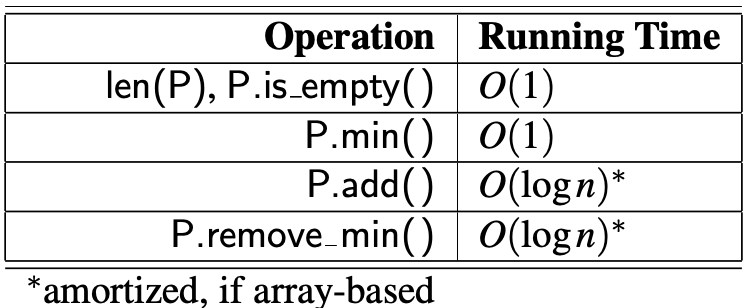

In [88]:
#---------R-9.1------------------
"""
O(log n) time to remove smallest element from heap
"""

'\nO(1) time to remove smallest element from heap\n'

In [89]:
#---------R-9.2------------------
""" T is heap when
p is the root of T , f(p)=0
left child of position q , f(p) = 2f(q)+1
right child of position q, f(p) = 2f(q)+2
"""

' T is heap when\np is the root of T , f(p)=0\nleft child of position q , f(p) = 2f(q)+1\nright child of position q, f(p) = 2f(q)+2\n'

In [94]:
#---------R-9.3------------------
UPQ = UnsortedPriorityQueue() 
UPQ.add(5,'A')
UPQ.add(4,'B')
UPQ.add(7,'F')
UPQ.add(1,'D')
UPQ.printQue()
#UPQ.min()
UPQ.remove_min()
UPQ.add(3,'J')
UPQ.add(6,'L')
UPQ.printQue()
UPQ.remove_min()
UPQ.remove_min()
UPQ.printQue()
UPQ.add(8,'G')
# len(UPQ)
UPQ.remove_min()
UPQ.add(2,'H')    
UPQ.remove_min()
UPQ.remove_min()
UPQ.printQue()

[(7, 'F'), (8, 'G')]

In [95]:
#---------R-9.4------------------
""" priority queue ADT can perform both functions.
1. Add element with timestamp as key to add to priority queue
2. Use remove_min on timestamp as key to remove min.
"""

' priority queue ADT can perform both functions.\n1. Add element with timestamp as key to add to priority queue\n2. Use remove_min on timestamp as key to remove min.\n'

In [99]:
#---------R-9.5------------------
"""
min method to run o(1), min element must be present in first position,
def add(self, key, value):
        'Add a key-value pair.'
        self._data.add_last(self._Item(key, value))
        
        add method will have to find min element and add accordingly.
"""
class min_unsorted(UnsortedPriorityQueue):
    def add(self, key, value):
        """Add a key-value pair."""
        newest = self._Item(key, value)
        walk = self._data.last()
        while walk is not None and newest < walk.element():
            walk = self._data.before(walk)
        if walk is None:
            self._data.add_first(newest)
        else:
            self._data.add_after(walk, newest)
            
    def min(self):
        """Return but do not remove (k,v) tuple with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' )
        p = self._data.first()
        item = p.element()
        return (item._key, item._value)
    
UPQ = min_unsorted() 
UPQ.add(5,'A')
UPQ.add(4,'B')
UPQ.add(7,'F')
UPQ.add(1,'D')
UPQ.printQue() 
UPQ.min()

(1, 'D')

In [101]:
#---------R-9.6------------------
class min_unsorted2(min_unsorted):
    def remove_min(self):
        """Remove and return (k,v) tuple with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' )
        item = self._data.delete(self._data.first())
        return (item._key, item._value)

UPQ = min_unsorted() 
UPQ.add(5,'A')
UPQ.add(4,'B')
UPQ.add(7,'F')
UPQ.add(1,'D')
UPQ.printQue() 
UPQ.min()  
UPQ.remove_min()
UPQ.printQue()

[(4, 'B'), (5, 'A'), (7, 'F')]

In [112]:
#---------R-9.7------------------
"""
(22,15,36,44,10,3,9,13,29,25)
unsorted list as selection sort of remove_min()

insert o(1) -- (22,15,36,44,10,3,9,13,29,25)
selection sort o(n)

(22,15,36,44,10,3,9,13,29,25)
(22,15,36,44,10,9,13,29,25)  -- 3
(22,15,36,44,10,13,29,25)  -- 3,9
(22,15,36,44,13,29,25)  -- 3,9,10
(22,15,36,44,29,25)  -- 3,9,10,13
(36,44,29,25)  -- 3,9,10,13,15,22
(36,44,29)  -- 3,9,10,13,15,22,25
(36,44)  -- 3,9,10,13,15,22,25,29
(44)  -- 3,9,10,13,15,22,25,29,36
()  -- 3,9,10,13,15,22,25,29,36,44

"""


'\n(22,15,36,44,10,3,9,13,29,25)\nunsorted list as selection sort of remove_min()\n\ninsert o(1) -- (22,15,36,44,10,3,9,13,29,25)\nselection sort o(n)\n\n(22,15,36,44,10,3,9,13,29,25)\n(22,15,36,44,10,9,13,29,25)  -- 3\n(22,15,36,44,10,13,29,25)  -- 3,9\n(22,15,36,44,13,29,25)  -- 3,9,10\n(22,15,36,44,29,25)  -- 3,9,10,13\n(36,44,29,25)  -- 3,9,10,13,15,22\n(36,44,29)  -- 3,9,10,13,15,22,25\n(36,44)  -- 3,9,10,13,15,22,25,29\n(44)  -- 3,9,10,13,15,22,25,29,36\n()  -- 3,9,10,13,15,22,25,29,36,44\n\n'

In [113]:
#---------R-9.8------------------
"""
(22,15,36,44,10,3,9,13,29,25)
sorted list as insert sort of remove_min()

insert sort o(n) -- 3,9,10,13,15,22,25,29,36,44
22 
15,22 --15
15,22,36 --36
15,22,36,44 --44
10,15,22,36,44 --10
3,10,15,22,36,44 --3
3,9,10,15,22,36,44 --9
3,9,13,10,15,22,36,44 --13
3,9,13,10,15,22,29,36,44 --29
3,9,13,10,15,22,25,29,36,44 --25
"""

'\n(22,15,36,44,10,3,9,13,29,25)\nsorted list as insert sort of remove_min()\n\ninsert sort o(n) -- 3,9,10,13,15,22,25,29,36,44\n22 \n15,22 --15\n15,22,36 --36\n15,22,36,44 --44\n10,15,22,36,44 --10\n3,10,15,22,36,44 --3\n3,9,10,15,22,36,44 --9\n3,9,13,10,15,22,36,44 --13\n3,9,13,10,15,22,29,36,44 --29\n3,9,13,10,15,22,25,29,36,44 --25\n'

In [104]:
#---------R-9.9------------------
""" n(n+1)/2 ~ n^2
"""

' n(n+1)/2 ~ n^2\n'

In [107]:
#---------R-9.10------------------
"""At which positions of a heap might the third smallest key be stored?

right child of 1st level, 0 level being the root 
"""

'At which positions of a heap might the third smallest key be stored?\n\n2nd or 3rd positions\n'

In [108]:
#---------R-9.11------------------
"""At which positions of a heap might the largest key be stored?

nth node at n level of the heap
"""

'At which positions of a heap might the largest key be stored?\n\nnth node at n level of the heap\n'

In [111]:
#---------R-9.12------------------
class maxPriorityQueue(PriorityQueueBase): # base class defines Item
    """A min-oriented priority queue implemented with a sorted list"""
    
    
    def __init__(self):
        """Create a new empty Priority Queue."""
        self._data = PositionalList()
        
    def __len__(self):
        """Return the number of items in the priority queue."""
        return len(self._data)
    
    def add(self, key, value):
        """Add a key-value pair."""
        newest = self._Item(key, value)
        walk = self._data.last()
        while walk is not None and newest > walk.element():
            walk = self._data.before(walk)
        if walk is None:
            self._data.add_first(newest)
        else:
            self._data.add_after(walk, newest)
        

    def min(self):
        """Return but do not remove (k,v) tuple with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' )
        p = self._data.first()
        item = p.element()
        return (item._key, item._value)

    def remove_min(self):
        """Remove and return (k,v) tuple with minimum key."""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' )
        item = self._data.delete(self._data.first())
        return (item._key, item._value)
    
    def printQue(self): # nonpublic utility
        """Print priority Queue value"""
        if self.is_empty(): # is empty inherited from base class
            raise Empty( 'Priority queue is empty' ) 
        d = []
        first = self._data.first()
        item1 = first.element()
        d.append((item1._key,item1._value))
        #d.append(first.getKeyValue())
        second = self._data.after(first)
        
        while second is not None:
            #d.append(second.getKeyValue())
            item2 = second.element()
            d.append((item2._key,item2._value))
            second = self._data.after(second)
                
        return d
    
SPQ = maxPriorityQueue() 
SPQ.add(5,'A')
SPQ.add(9,'C')
SPQ.add(3,'B')
SPQ.add(7,'D')
SPQ.printQue()    

[(9, 'C'), (7, 'D'), (5, 'A'), (3, 'B')]

In [115]:
#---------R-9.13------------------
"""ascending order : Max heap
desending order : Min heap  """  
""" inplace sort heat sort algorith (2,5,16,4,10,23,39,18,26,15).
phase 1 construct heap 
  [2,5,16,4,10,23,39,18,26,15]
  [2,5,39,4,10,23,16,18,26,15]
  [39,5,2,4,10,23,16,18,26,15]
  [39,5,23,26,15,2,16,18,4,10]
  [39,26,23,5,15,2,16,18,4,10]
  [39,26,23,18,15,2,16,5,4,10]
  
phase 2 sort algorith      sorted
  [10,26,23,18,15,2,16,5,4|39]
  [26,10,23,18,15,2,16,5,4|39]
  [26,18,23,10,15,2,16,5,4|39]
  [4,18,23,10,15,2,16,5|26,39]
  [23,18,4,10,15,2,16,5|26,39] 
  [23,18,16,10,15,2,4,5|26,39] 
  [5,18,16,10,15,2,4|23,26,39]
  [18,5,16,10,15,2,4|23,26,39]
  [18,15,16,10,5,2,4|23,26,39]
  [4,15,16,10,5,2|18,23,26,39]
  [16,15,4,10,5,2|18,23,26,39]
  [2,15,4,10,5|16,18,23,26,39]
  [15,2,4,10,5|16,18,23,26,39]
  [15,10,4,2,5|16,18,23,26,39]
  [5,10,4,2|15,16,18,23,26,39]
  [10,5,4,2|15,16,18,23,26,39]
  [2,5,4|10,15,16,18,23,26,39]
  [5,2,4|10,15,16,18,23,26,39]
  [2,4|5,10,15,16,18,23,26,39]
  [4,2|5,10,15,16,18,23,26,39]
  [2|4,5,10,15,16,18,23,26,39]
  [2,4,5,10,15,16,18,23,26,39]
  
"""

' inplace sort heat sort algorith (2,5,16,4,10,23,39,18,26,15).\nphase 1 construct heap \n  [2,5,16,4,10,23,39,18,26,15]\n  [2,5,39,4,10,23,16,18,26,15]\n  [39,5,2,4,10,23,16,18,26,15]\n  [39,5,23,26,15,2,16,18,4,10]\n  [39,26,23,5,15,2,16,18,4,10]\n  [39,26,23,18,15,2,16,5,4,10]\n  \nphase 2 sort algorith      sorted\n  [10,26,23,18,15,2,16,5,4|39]\n  [26,10,23,18,15,2,16,5,4|39]\n  [26,18,23,10,15,2,16,5,4|39]\n  [4,18,23,10,15,2,16,5|26,39]\n  [23,18,4,10,15,2,16,5|26,39] \n  [23,18,16,10,15,2,4,5|26,39] \n  [5,18,16,10,15,2,4|23,26,39]\n  [18,5,16,10,15,2,4|23,26,39]\n  [18,15,16,10,5,2,4|23,26,39]\n  [4,15,16,10,5,2|18,23,26,39]\n  [16,15,4,10,5,2|18,23,26,39]\n  [2,15,4,10,5|16,18,23,26,39]\n  [15,2,4,10,5|16,18,23,26,39]\n  [15,10,4,2,5|16,18,23,26,39]\n  [5,10,4,2|15,16,18,23,26,39]\n  [10,5,4,2|15,16,18,23,26,39]\n  [2,5,4|10,15,16,18,23,26,39]\n  [5,2,4|10,15,16,18,23,26,39]\n  [2,4|5,10,15,16,18,23,26,39]\n  [4,2|5,10,15,16,18,23,26,39]\n  [2|4,5,10,15,16,18,23,26,39]\n  [2,

In [116]:
#---------R-9.14------------------
"""
yes its not a heap because it doesn't satisfy min, max criteria with the parent level
f(p)=0
f(p)= 2f(q)+1
f(p)=2f(q)+2

"""

'\nyes its a heap because it satisfy\nf(p)=0\nf(p)= 2f(q)+1\nf(p)=2f(q)+2\n\n'

In [117]:
#---------R-9.15------------------
"""
because the way heaps are constructed , it will always have a left child 
with 
f(p)=0
f(p)= 2f(q)+1
f(p)=2f(q)+2
"""

'\nbecause the way heaps are constructed , it will always have a left child \nwith \nf(p)=0\nf(p)= 2f(q)+1\nf(p)=2f(q)+2\n'

In [118]:
#---------R-9.16------------------

"""    heap H with 7 entities
                (1)
              /     \
            (2)     (3)
           /   \   /   \
          (4)  (5)(6)  (7)
          
        preorder - 1,2,4,5 ,3,6,7
        postorder- 2,4,5,3,6,7,1
        inorder - 2,4,5,1,3,6,7
        
        hence not in increasing or decreaing order
"""

'    heap H with 7 entities\n                (1)\n              /                 (2)     (3)\n           /   \\   /             (4)  (5)(6)  (7)\n          \n        preorder - 1,2,4,5 ,3,6,7\n        postorder- 2,4,5,3,6,7,1\n        inorder - 2,4,5,1,3,6,7\n        \n        hence not in increasing or decreaing order\n'

In [119]:
#---------R-9.17------------------
"""[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
                                   
                                       (1)
                                 /           \
                                (2)           (3)
                               /. \.       /      \
                              (4) (5)     (6)     (7)
                             / \  / \    / \       / \
                          (8)(9) (10)(11)(12)(13)(14)(15)
                          
                          
           preorder - 1,2,4,5,8,9,10,11,3,6,7,12,13,14,15
                      0,1,3,4,7,8,9,10,2,5,6,11,12,13,14
           inorder - 2,4,5,8,9,10,11,1,3,6,7,12,13,14,15
                     1,3,4,7,8,9,10,0,2,5,6,11,12,13,14
           postorder - 2,4,5,8,9,10,11,3,6,7,12,13,14,15,1
                      1,3,4,7,8,9,10,2,5,6,11,12,13,14,0
    
"""

'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]\n    0,1,2,3,4,5,6,7,8,9,10,11,12,13,14\n                                   \n                                       (1)\n                                 /                                           (2)           (3)\n                               /. \\.       /                                    (4) (5)     (6)     (7)\n                             / \\  / \\    / \\       /                           (8)(9) (10)(11)(12)(13)(14)(15)\n                          \n                          \n           preorder - 1,2,4,5,8,9,10,11,3,6,7,12,13,14,15\n                      0,1,3,4,7,8,9,10,2,5,6,11,12,13,14\n           inorder - 2,4,5,8,9,10,11,1,3,6,7,12,13,14,15\n                     1,3,4,7,8,9,10,0,2,5,6,11,12,13,14\n           postorder - 2,4,5,8,9,10,11,3,6,7,12,13,14,15,1\n                      1,3,4,7,8,9,10,2,5,6,11,12,13,14,0\n    \n'

In [120]:
#---------R-9.18------------------
"""
∑𝑖=1𝑛−1lg(𝑛−𝑖)=lg((𝑛−1)!)=Θ(𝑛lg𝑛)

By the way, building a simple binary heap only takes  𝑂(𝑛)  time.

Construction:  𝑂(𝑛) , you have to do this only once.

Removing an element  𝑂(log(𝑘))  if you have k elements in heap.

Removing n elements

𝑂(log(𝑛)+log(𝑛−1)+log(𝑛−2)+....+log(1))=𝑂(log(𝑛!))=𝑂(𝑛log(𝑛)) 

Last reduction is called Stirling's approximation.

So total time
𝑇(𝑛)=𝑂(𝑛)+𝑂(𝑛log(𝑛))=𝑂(𝑛log(𝑛))"""

"\n∑𝑖=1𝑛−1lg(𝑛−𝑖)=lg((𝑛−1)!)=Θ(𝑛lg𝑛)\n\nBy the way, building a simple binary heap only takes  𝑂(𝑛)  time.\n\nConstruction:  𝑂(𝑛) , you have to do this only once.\n\nRemoving an element  𝑂(log(𝑘))  if you have k elements in heap.\n\nRemoving n elements\n\n𝑂(log(𝑛)+log(𝑛−1)+log(𝑛−2)+....+log(1))=𝑂(log(𝑛!))=𝑂(𝑛log(𝑛)) \n\nLast reduction is called Stirling's approximation.\n\nSo total time\n𝑇(𝑛)=𝑂(𝑛)+𝑂(𝑛log(𝑛))=𝑂(𝑛log(𝑛))"

In [121]:
#---------R-9.19------------------

"""    heap H with 7 entities
                (1)
              /     \
            (2)     (3)
           /   \   /   \
          (4)  (5)(6)  (7)
          
        preorder - 1,2,4,5 ,3,6,7"""

'    heap H with 7 entities\n                (1)\n              /                 (2)     (3)\n           /   \\   /             (4)  (5)(6)  (7)\n          \n        preorder - 1,2,4,5 ,3,6,7'

In [122]:
#---------R-9.20------------------

"""    heap H with 7 entities
                (1)
              /     \
            (2)     (3)
           /   \   /   \
          (4)  (5)(6)  (7)
          
        postorder- 2,4,5,3,6,7,1"""

'    heap H with 7 entities\n                (1)\n              /                 (2)     (3)\n           /   \\   /             (4)  (5)(6)  (7)\n          \n        postorder- 2,4,5,3,6,7,1'

In [124]:
#---------R-9.21------------------
"""removing 16,X will be O(1) operation with no bubbbling (up or down)
because heap is still balanced, element is removed with locator
"""

'removing 16,X will be O(1) operation with no bubbbling (up or down)\nbecause heap is still balanced, element is removed with locator\n'

In [ ]:
#---------R-9.21------------------
""" swap 5,a with 18 will be o(1), since locator is there.
9 will be swap with 18 and 12 will be swap with 18
"""

In [123]:
#---------R-9.25------------------
"""
 [9,7,5,2,6,4]                   (9)
                                 / \
                                (7) (5)
                               /  \ /
                            (2)  (6)(4)
                            
            sorted 
 [4,7,5,2,6|9]
                                 (4)          
                                 / \
                                (7) (5)
                               /  \ 
                            (2)  (6)   
                            
                                 (7)          
  [7,4,5,2,6|9]                  / \
                                (4) (5)
                               /  \ 
                            (2)  (6)
                            
                                 (7)          
  [7,6,5,2,4|9]                  / \
                                (6) (5)
                               /  \ 
                            (2)  (4) 
                            
                                 (4)          
                                 / \
 [4,6,5,2|7,9]                 (6) (5)
                               /  
                            (2)   
                            


 [6,4,5,2|7,9]                
                              (6)
                              / \
                             (4) (5)
                            /
                          (2)

[2,4,5|6,7,9]
                              (2)
                              / \
                             (4) (5)
                             
 [5,4,2|6,7,9]                            
                              (5)
                              / \
                             (4) (2)
                             
  [4,2|5,6,7,9]                           
                             
                             (2)
                              / 
                             (4) 
                       
   [2,4|5,6,7,9]                    
                             (4)
                              / 
                             (2)
    [2|4,5,6,7,9]                         
                             (2)
                             
     
     [2,4,5,6,7,9]          ()
                             
"""

'\n [9,7,5,2,6,4]                   (9)\n                                 /                                 (7) (5)\n                               /  \\ /\n                            (2)  (6)(4)\n                            \n            sorted \n [4,7,5,2,6|9]\n                                 (4)          \n                                 /                                 (7) (5)\n                               /  \\ \n                            (2)  (6)   \n                            \n                                 (7)          \n  [7,4,5,2,6|9]                  /                                 (4) (5)\n                               /  \\ \n                            (2)  (6)\n                            \n                                 (7)          \n  [7,6,5,2,4|9]                  /                                 (6) (5)\n                               /  \\ \n                            (2)  (4) \n                            \n                                 (4)  